## Introduction

This notebook gives an overview of the `pulser-diff` package and introduces its features and possibilities. `pulser-diff` in its essence is a PyTorch-based differentiable backend for [Pulser](https://pulser.readthedocs.io/en/stable/) framework that allows composing, simulating and executing pulse sequences for neutral-atom quantum devices. Being differentiable means that the result of Schrodinger equation solver can be differentiated with respect to sequence evaluation times $\{t_i\}_{i=1}^{N}$ or any parameters that define the constituent pulses of the sequence, e. g., amplitude $\Omega$, detuning $\delta$ or phase $\Phi$. This feature is facilitated by the auto-differentiation capabilities of the underlying `torch` library. 

Differentiability of `pulser-diff`'s simulation result $\psi(\theta_i)$ with respect to various sequence parameters $\theta_i$ also means that user can implement optimization strategies based on minimization of an arbitrary user-defined loss function $l(\theta_i)$. This opens the possibility to optimize pulse parameters in different contexts, such as finding the best parameters for some state preparation problem or the optimal shape of pulses that implement the desired gate with highest fidelity on a given quantum machine with specific hardware constraints. 

In the following sections we will present both the low-level features of `pulser-diff` showing how to calculate explicit derivatives and visualize them and the higher-level optimization API for various pulse optimization tasks.

## 1. Derivative calculation

First we import the necessary objects from `pulser` and `pyqtorch`.

In [1]:
import torch

from pulser import Sequence, Pulse, Register
from pulser.devices import MockDevice
from pulser.waveforms import BlackmanWaveform, RampWaveform

from pulser_diff.backend import TorchEmulator
from pulser_diff.derivative import deriv_time, deriv_param
from pulser_diff.utils import IMAT, ZMAT, kron

import matplotlib.pyplot as plt
from scipy import interpolate

from pyqtorch.utils import SolverType

### 1.1 Defining the sequence

Since `pulser-diff` is a backend of Pulser, the general workflow of defining a pulse sequence is identical. Thus, first we define the register. Note that the coordinates of qubits $(x_i, y_i)$ are differentiable parameters.

In [2]:
# define coordinates of 4 qubits as torch tensors
# requires_grad=True instructs the auto-differentiation engine that gradients will be stored for these tensors 
# that will allow derivatives with respect to these parameters be calculated
q0_coords = torch.tensor([0.0, 0.0], requires_grad=True)
q1_coords = torch.tensor([0.0, 8.0], requires_grad=True)
q2_coords = torch.tensor([8.0, 0.0], requires_grad=True)
q3_coords = torch.tensor([8.0, 8.0], requires_grad=True)

# create register
reg = Register({"q0": q0_coords, "q1": q1_coords, "q2": q2_coords, "q3": q3_coords})
print(reg)

Register({'q0': tensor([0., 0.], dtype=torch.float64, grad_fn=<SelectBackward0>), 'q1': tensor([0., 8.], dtype=torch.float64, grad_fn=<SelectBackward0>), 'q2': tensor([8., 0.], dtype=torch.float64, grad_fn=<SelectBackward0>), 'q3': tensor([8., 8.], dtype=torch.float64, grad_fn=<SelectBackward0>)})


Now we create an empty sequence, define channels and define the parameters of pulses that will be added to the sequence.

In [3]:
# create sequence and declare channels
seq = Sequence(reg, MockDevice)
seq.declare_channel("rydberg_global", "rydberg_global")

# define pulse parameters
omega = torch.tensor([5.0], requires_grad=True)
start_det = torch.tensor([-5.0], requires_grad=True)
area = torch.tensor([torch.pi], requires_grad=True)
det = torch.tensor([0.0], requires_grad=True)
phase = torch.tensor([0.0], requires_grad=True)

# define time-dependent waveforms
amp_wf = BlackmanWaveform(800, area)
det_wf = RampWaveform(800, start_det, 0.0)

# add pulses
seq.add(Pulse(amp_wf, det_wf, 0), "rydberg_global")
seq.add(Pulse.ConstantPulse(800, omega, det, phase), "rydberg_global")

Note that all pulse parameters above created as tensors are created with `requires_grad=True` argument, however if differentiation with respect to some of them won't be performed, it is beneficial to set `requires_grad=False` for those parameters in order to save memory. 

When creating pulses we can mix `torch` tensors and simple `float` values as pulse parameters.

Sequence simulation is performed using the standard Pulser interface, however we use the `torch`-based `TorchEmulator` class from `pulser-diff` to perform the simulation instead of the `QutipEmulator` that uses `qutip` package in Pulser.

In [4]:
sim = TorchEmulator.from_sequence(seq, sampling_rate=0.1)
results = sim.run(time_grad=True, dist_grad=True, solver=SolverType.DP5_SE)

Argument `time_grad=True` instructs the simulation to store gradients for evaluation times, thus allowing later to calculate derivative of the output with respect to these times. `dist_grad=True` means that we will be able to calculate derivatives with respect to inter-qubit distances $r_{ij}$ . We can also specify, what solver from `pyqtorch` library to use for quantum dynamics simulation: `DP5_SE` - selects the Dormand-Prince-5 state vector solver, `KRYLOV_SE` selects the Krylov subspace method state vector solver.

`results` object contains the values of the system's wavefunction at times stored in the `sim.evaluation_times` tensor. Both of these quantities are `torch` tensors.

In [5]:
print("Evaluation times:")
print(sim.evaluation_times)
print()
print("Wavefunctions:")
print(results.states)

Evaluation times:
tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1610, 0.1710,
        0.1810, 0.1910, 0.2010, 0.2110, 0.2210, 0.2310, 0.2410, 0.2510, 0.2610,
        0.2710, 0.2810, 0.2910, 0.3010, 0.3110, 0.3220, 0.3320, 0.3420, 0.3520,
        0.3620, 0.3720, 0.3820, 0.3920, 0.4020, 0.4120, 0.4220, 0.4320, 0.4420,
        0.4520, 0.4620, 0.4720, 0.4830, 0.4930, 0.5030, 0.5130, 0.5230, 0.5330,
        0.5430, 0.5530, 0.5630, 0.5730, 0.5830, 0.5930, 0.6030, 0.6130, 0.6230,
        0.6330, 0.6440, 0.6540, 0.6640, 0.6740, 0.6840, 0.6940, 0.7040, 0.7140,
        0.7240, 0.7340, 0.7440, 0.7540, 0.7640, 0.7740, 0.7840, 0.7940, 0.8050,
        0.8150, 0.8250, 0.8350, 0.8450, 0.8550, 0.8650, 0.8750, 0.8850, 0.8950,
        0.9050, 0.9150, 0.9250, 0.9350, 0.9450, 0.9550, 0.9660, 0.9760, 0.9860,
        0.9960, 1.0060, 1.0160, 1.0260, 1.0360, 1.0460, 1.0560, 1.0660, 1.0760,
        1.0860, 1.0960

Using the `results` object we can further calculate the necessary quantities, e. g., using the `expect` method get the expectation values at each evaluation time moment with some observable $\hat{C}$. 

In [6]:
# create total magnetization observable
n_qubits = len(reg._coords)
total_magnetization = []
for i in range(n_qubits):
    tprod = [IMAT for _ in range(n_qubits)]
    tprod[i] = ZMAT
    total_magnetization.append(kron(*tprod))
total_magnetization = sum(total_magnetization)

# calculate expectation values
exp_val = results.expect([total_magnetization])[0].real

### 1.2 Calculating derivative with respect to time

To calculate derivative with respect to time we get the evaluation times tensor and use `deriv_time` function.

In [7]:
# calculate derivative
eval_times = sim.evaluation_times
pulse_endtimes = sim.endtimes
grad_time = deriv_time(f=exp_val, times=eval_times, pulse_endtimes=pulse_endtimes)

The last argument `pulse_endtimes` to function `deriv_time` is used to provide the indices of pulse start/end times in the `eval_times` tensor. This is needed to fix possible spikes of derivative on the boundary between two ideal pulses.

In order to check that the calculated time derivative is correct we can create an interpolated function from expectation values using `scipy.interpolate` and find the corresponding derivative.

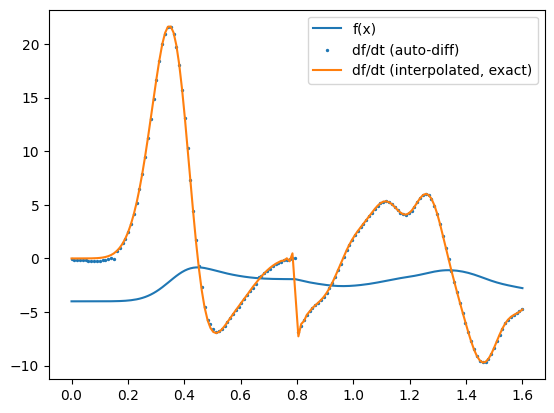

In [8]:
# calculate exact derivative with respect to time
x = eval_times.detach().numpy()
y = exp_val.detach().numpy()
interp_fx = interpolate.UnivariateSpline(x, y, k=5, s=0)
dfdt_exact = interp_fx.derivative()(x)

# visualize expectation values and time derivatives
plt.plot(x, y, label="f(x)")
plt.scatter(x, grad_time.detach().numpy(), s=2, label="df/dt (auto-diff)")
plt.plot(x, dfdt_exact, label="df/dt (interpolated, exact)")
plt.legend()

We can see that time derivative calculated using `torch` auto-differentiation engine closely corresponds to the exact derivative.

### 1.3 Calculating derivative with respect to pulse/register parameters

The workflow is generally the same as when calculating time derivative only now we will use function `deriv_param` provided by `pulser-diff`.

Let us calculate derivatives of expectation value with respect to amplitude `omega` of the second constant pulse of the sequence, to coordinates of qubit `q1` and inter-qubit distance `r` between qubits `q1` and `q3`. We can obtain all these derivative values by passing the necessary parameters to `deriv_param` in a single list.

In [9]:
exp_val

tensor([-4.0000, -4.0000, -4.0000, -4.0000, -4.0000, -4.0000, -4.0000, -3.9999,
        -3.9998, -3.9996, -3.9992, -3.9986, -3.9975, -3.9959, -3.9933, -3.9894,
        -3.9831, -3.9746, -3.9629, -3.9468, -3.9254, -3.8971, -3.8606, -3.8141,
        -3.7559, -3.6843, -3.5975, -3.4941, -3.3729, -3.2333, -3.0754, -2.9000,
        -2.6886, -2.4832, -2.2696, -2.0530, -1.8390, -1.6338, -1.4434, -1.2732,
        -1.1279, -1.0108, -0.9236, -0.8665, -0.8380, -0.8355, -0.8553, -0.8932,
        -0.9504, -1.0120, -1.0789, -1.1482, -1.2174, -1.2850, -1.3497, -1.4111,
        -1.4687, -1.5226, -1.5727, -1.6192, -1.6620, -1.7013, -1.7371, -1.7693,
        -1.8005, -1.8251, -1.8465, -1.8647, -1.8800, -1.8925, -1.9025, -1.9103,
        -1.9163, -1.9206, -1.9237, -1.9256, -1.9268, -1.9274, -1.9276, -1.9338,
        -2.0003, -2.0664, -2.1265, -2.1816, -2.2326, -2.2803, -2.3253, -2.3679,
        -2.4081, -2.4455, -2.4796, -2.5097, -2.5352, -2.5553, -2.5695, -2.5775,
        -2.5792, -2.5745, -2.5642, -2.54

In [10]:
# create tensor of times (in ns) where derivative will be evaluated
times = torch.linspace(0.0, 1600, 40)

# we want to calculate derivative with respect to distance between qubits q0 and q3
qq_distances = sim.qq_distances
r = qq_distances["q0-q3"]

# calculate derivative values at each time
diff_params = [omega, q1_coords, r]
grads = []
for t in times:
    grad_param = deriv_param(f=exp_val, x=diff_params, times=eval_times, t=t)
    grads.append(torch.hstack(grad_param))
grads = torch.stack(grads)

Similarly we can calculate derivatives with respect to qubit coordinates.

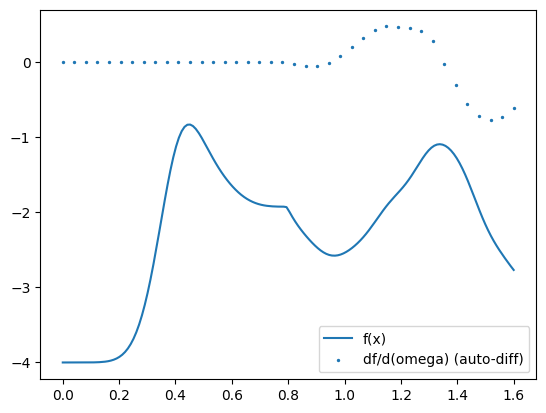

In [11]:
# visualize derivative with respect to amplitude
plt.plot(x, y, label="f(x)")
plt.scatter(times.numpy()/1000, grads[:,0].numpy(), s=2, label="df/d(omega) (auto-diff)")
plt.legend()

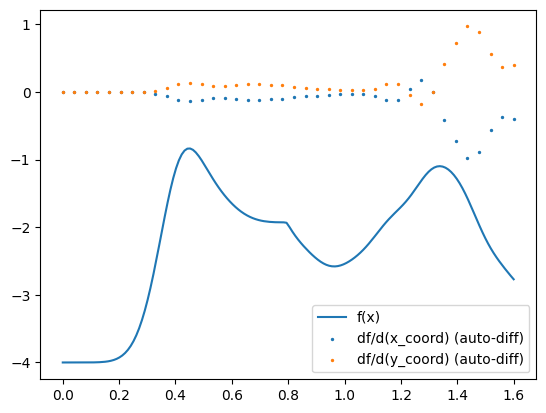

In [12]:
# visualize derivatives with respect to coordinates
plt.plot(x, y, label="f(x)")
plt.scatter(times.numpy()/1000, grads[:,1].numpy(), s=2, label="df/d(x_coord) (auto-diff)")
plt.scatter(times.numpy()/1000, grads[:,2].numpy(), s=2, label="df/d(y_coord) (auto-diff)")
plt.legend()

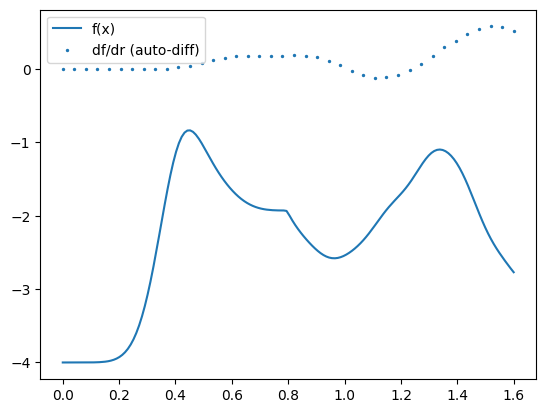

In [13]:
# visualize derivative with repsect to inter-qubit distance
plt.plot(x, y, label="f(x)")
plt.scatter(times.numpy()/1000, grads[:, 3].numpy(), s=2, label="df/dr (auto-diff)")
plt.legend()

## 2. Sequence optimization

In previous section we demonstrated that `pulser-diff` is able to calculate first-order derivatives ${\rm d}l(\theta)/{\rm d}\theta_{i}$ of some output function $l(\theta)$ with respect to various parameters of pulses and underlying register $\theta_i$. This feature can be directly used if one treats `pulser-diff` in the context of machine learning as a framework where one minimizes a loss function by applying gradient-based approaches to optimize the values of underlying system parameters. Here the system is the pulse sequence, loss function can be any function of the output of the state-vecor simulator and the optimizable parameters are pulse, register and observalbe parameters. Let us now demonstrate how such optimization can be performed.

Optimization API of `pulser-diff` is built around `QuantumModel` class that enables the conversion of ordinary Pulser sequence into a `torch.nn.Module` that allows seamless integration into usual PyTorch ML workflows including optimizer and scheduler selection as well as optimization loop customization. Let us import the `QuantumModel` object.

In [14]:
from pulser_diff.model import QuantumModel

### 2.1 Toy model optimization

To show the basic workflow of sequence optimization we define a toy problem. Let us assume that we need to find the parameters of a pulse sequence such that the expectation value $f(\theta)=\left\langle \psi(\theta)\right|\hat{C}\left|\psi(\theta)\right\rangle $ of an observable $\hat{C}$ is equal to a predifined value, say $f_0=-0.5$. We can achieve this goal by optimizing any or all parameters from these two groups:

1. Pulse parameters - amplitude $\Omega$, detuning $\delta$, phase $\phi$, duration $\tau_n$
2. Register parameters - qubit coordinates $(x_i, y_i)$

<div class="alert alert-block alert-warning">
<b>Warning:</b> Pulse duration optimization is currently supported for sequences containing only constant pulses.
</div>

We first define a sequence consisting of one constant and one time-dependent pulse and assume that we want to optimize the amplitude of the constant pulse and the area of the time-dependent one.

In [46]:
# create register
reg = Register.rectangle(1, 2, spacing=8, prefix="q")

# create sequence and declare channels
seq = Sequence(reg, MockDevice)
seq.declare_channel("rydberg_global", "rydberg_global")

# declare sequence variables
omega_param = seq.declare_variable("omega")
area_param = seq.declare_variable("area")

# create pulses
pulse_const = Pulse.ConstantPulse(1000, omega_param, 0.0, 0.0)
amp_wf = BlackmanWaveform(800, area_param)
det_wf = RampWaveform(800, 5.0, 0.0)
pulse_td = Pulse(amp_wf, det_wf, 0)

# add pulses
seq.add(pulse_const, "rydberg_global")
seq.add(pulse_td, "rydberg_global")

The sequence we created is a standard Pulser parametrized sequence as is evident from declaring two variables `omega` for constant pulse's amplitude and `area` for Blackman pulse's area. Generally, `pulser-diff` utilizes Pulser's variable system to denote the sequence parameters that have to be optimized. This works for any pulse parameter that supports Pulser's `Variable` object as an argument.

To optimize this sequence we first have to wrap it with a `QuantumModel` object and supply it with initial values for `omega` and `area`.

In [47]:
# define pulse parameters
omega = torch.tensor([5.0], requires_grad=True)
area = torch.tensor([torch.pi], requires_grad=True)

# create quantum model from sequence
trainable_params = {"omega": omega, "area": area}
constraints = {
    "omega": {"min": 4.5, "max": 5.5}
}
model = QuantumModel(seq, trainable_params, constraints=constraints, sampling_rate=0.5, solver=SolverType.KRYLOV_SE)

# list trainable parameters of the model
print()
for name, param in model.named_parameters():
    print(name)
    print(param)
    print('-------')


seq_param_values.area
Parameter containing:
tensor([3.1416], requires_grad=True)
-------
seq_param_values.omega
Parameter containing:
tensor([5.], requires_grad=True)
-------


We can see from the code snippet above that initial values for the optimizable parameters are given as `torch.Tensor` objects with `requires_grad=True` property. This falls in line with the paradigm of PyTorch of creating a computational graph that facilitates gradient calculations with respect to leaf nodes - in our case the user-created `omega` and `area` tensors. Note that `trainable_params` dict key values must be identical to the Pulser sequence variables defined previously.

An optional dict can be passed to `QuantumModel` constructor with argument `constraints`, that defines the min/max range of optimizable parameters. Here we specified that the `omega` parameter value must not fall out of the range $[4.5, 5.5]$. Internally such constraints are enforced by using `torch.clamp` function that allows gradient flow through it and simultaneously keeps the parameter value strictly in range.

Finally, we print the optimizable parameters of the created `QuantumModel` instance to confirm that `omega` and `area` are indeed registered and will be visible to the PyTorch optimizer. The optimizer is defined in a standard way along with the loss function that in our case is the simple MSE loss.

In [48]:
# define loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

With loss function and optimizer in place we can now construct an optimization loop to solve the problem. 

In [49]:
# print initial expectation value as a result of simulating initial sequence
_, init_exp_val = model.expectation()
print("Initial expectation value:", init_exp_val[-1])
print()

# optimize model parameters so that the final output expectation value matches the predefined value
epochs = 100
target_value = torch.tensor(-0.5, dtype=torch.float64)
for t in range(epochs):
    # calculate prediction and loss
    _, exp_val = model.expectation()
    loss = loss_fn(exp_val.real[-1], target_value)

    # standard backpropagation
    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()

    # enforce constraints on optimizable parameters
    model.check_constraints()

    print(f"[{t}] loss: {loss:>7f}")

    if loss < 0.00001:
        break

    # update sequence with changed pulse parameter values
    model.update_sequence()

# print expectation value with optimized model
_, init_exp_val = model.expectation()
print()
print("Optimized expectation value:", init_exp_val[-1])
print()

Initial expectation value: tensor(-1.2763+0.j, dtype=torch.complex128, grad_fn=<SelectBackward0>)

[0] loss: 0.602630
[1] loss: 0.511404
[2] loss: 0.416565
[3] loss: 0.323062
[4] loss: 0.235741
[5] loss: 0.158972
[6] loss: 0.096202
[7] loss: 0.049484
[8] loss: 0.019127
[9] loss: 0.003641
[10] loss: 0.000086
[11] loss: 0.003037
[12] loss: 0.005175
[13] loss: 0.007339
[14] loss: 0.009370
[15] loss: 0.011185
[16] loss: 0.012749
[17] loss: 0.014054
[18] loss: 0.015110
[19] loss: 0.015934
[20] loss: 0.016543
[21] loss: 0.016714
[22] loss: 0.016053
[23] loss: 0.014692
[24] loss: 0.012802
[25] loss: 0.010579
[26] loss: 0.008227
[27] loss: 0.005940
[28] loss: 0.003890
[29] loss: 0.002212
[30] loss: 0.000992
[31] loss: 0.000264
[32] loss: 0.000003

Optimized expectation value: tensor(-0.4983+0.j, dtype=torch.complex128, grad_fn=<SelectBackward0>)



The optimization loop above folows the standard PyTorch rules with a couple of additions. Namely, we call `check_constraints()` method of the `model` to ensure that all optimizable parameters fall in range with any given constraints. Then `update_sequence()` method is called that reconstructs the underlying Pulser sequence with optimized values of parameters. This concludes a single optimization iteration and prepares for the next one. 

As we can see, after 32 iterations the loss decreased significantly and the target value of $-0.5$ was achieved with high accuracy. Printing the optimizable parameters of the model confirms that their values indeed changed.

In [50]:
print()
for name, param in model.named_parameters():
    print(name, param)
    print('-------')


seq_param_values.area Parameter containing:
tensor([2.5058], requires_grad=True)
-------
seq_param_values.omega Parameter containing:
tensor([4.6157], requires_grad=True)
-------


### 2.2 Pulse shape optimization